# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: choose a random action
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose the action with the highest Q-value
            state = self.environment.current_location
            q_values = self.q_table[state]
            max_q = max(q_values.values())
            actions_with_max_q = [action for action, q_value in q_values.items() if q_value == max_q]
            action = np.random.choice(actions_with_max_q)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        old_q_value = self.q_table[old_state][action]
        future_q_values = self.q_table[new_state].values()
        max_future_q_value = max(future_q_values)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_q_value - old_q_value)
        self.q_table[old_state][action] = new_q_value

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

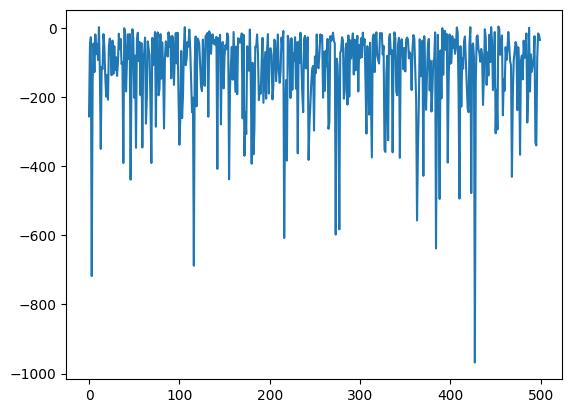

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

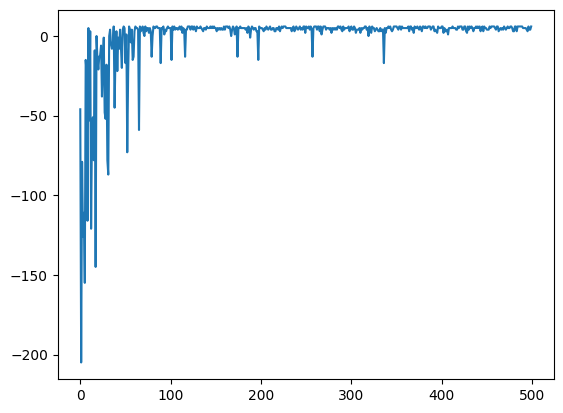

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.39
	DOWN
		-0.42727100000000007
	LEFT
		-0.4
	RIGHT
		0.09033106179590705
(0, 1)
	UP
		-0.2
	DOWN
		-0.201
	LEFT
		-0.30528620489
	RIGHT
		6.076031343325056
(0, 2)
	UP
		4.647491452826415
	DOWN
		3.211125554315023
	LEFT
		1.9379255758428373
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.7518502629969599
	DOWN
		0.7014778851091727
	LEFT
		9.999885661887271
	RIGHT
		0.028151838914138597
(0, 5)
	UP
		-0.1
	DOWN
		-0.11100000000000002
	LEFT
		2.8544592409573246
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.3109
	LEFT
		-0.18255900679844045
	RIGHT
		-0.31000000000000005
(0, 7)
	UP
		-0.4
	DOWN
		-0.399
	LEFT
		-0.469462155828329
	RIGHT
		-0.4
(1, 0)
	UP
		-0.6322439000000001
	DOWN
		-0.6705350640137901
	LEFT
		-0.6
	RIGHT
		-0.5542816729610001
(1, 1)
	UP
		-0.37720000000000004
	DOWN
		-0.3271
	LEFT
		-0.41000000000000003
	RIGHT
		2.8697382223353562
(1, 2)
	UP
		8.999999999999986
	DOWN
		4.304006376305353
	LEFT
		0.0411127

Change Grid Size to see the execution
time and the time to converge changes

Execution time: 11.290054082870483 seconds


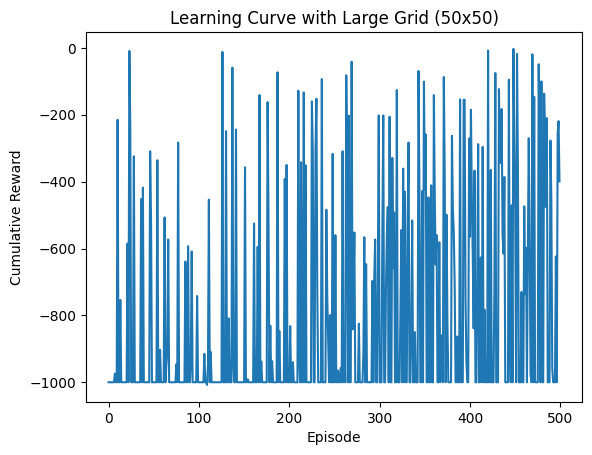

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld with a larger grid size (50x50)
        self.height = 50
        self.width = 50
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = (25, np.random.randint(0, 50))

        # Set locations for the bomb and the gold
        self.bomb_location = (10, 25)
        self.gold_location = (0, 25)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: choose a random action
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose the action with the highest Q-value
            state = self.environment.current_location
            q_values = self.q_table[state]
            max_q = max(q_values.values())
            actions_with_max_q = [action for action, q_value in q_values.items() if q_value == max_q]
            action = np.random.choice(actions_with_max_q)
        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        old_q_value = self.q_table[old_state][action]
        future_q_values = self.q_table[new_state].values()
        max_future_q_value = max(future_q_values)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_q_value - old_q_value)
        self.q_table[old_state][action] = new_q_value

def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

# Initialize environment with a large grid
large_environment = GridWorld()
large_agentQ = Q_Agent(large_environment)

# Measure execution time
start_time = time.time()

# Note the learn=True argument!
large_reward_per_episode = play(large_environment, large_agentQ, trials=500, learn=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Simple learning curve for the large grid
plt.plot(large_reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve with Large Grid (50x50)')
plt.show()

In [ ]:
# Optionally print out the Q-table
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

pretty(large_agentQ.q_table)

Streaming output truncated to the last 5000 lines.
		-4.613337431174266
	LEFT
		-4.569756189300949
	RIGHT
		-4.533354053929522
(38, 45)
	UP
		-4.5110215213420695
	DOWN
		-4.495917744441946
	LEFT
		-4.569275651990255
	RIGHT
		-4.524342000629807
(38, 46)
	UP
		-4.577435023412051
	DOWN
		-4.54984414813106
	LEFT
		-4.504306530027074
	RIGHT
		-4.515311574523545
(38, 47)
	UP
		-4.549140094995811
	DOWN
		-4.522902086974819
	LEFT
		-4.584090682860791
	RIGHT
		-4.4946717493779635
(38, 48)
	UP
		-4.502053294087055
	DOWN
		-4.544418098295986
	LEFT
		-4.582693903796938
	RIGHT
		-4.573911650738976
(38, 49)
	UP
		-4.510531785364456
	DOWN
		-4.5307004995723155
	LEFT
		-4.574954369640765
	RIGHT
		-4.47717864624651
(39, 0)
	UP
		-4.539349946639328
	DOWN
		-4.471866173921759
	LEFT
		-4.5
	RIGHT
		-4.558616803767082
(39, 1)
	UP
		-4.573941654246152
	DOWN
		-4.541272416317755
	LEFT
		-4.5552333988686415
	RIGHT
		-4.614425512613649
(39, 2)
	UP
		-4.582709391978989
	DOWN
		-4.562911271832264
	LEFT
		-4.6218

# DQN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class GridWorld:
    def __init__(self):
        self.height = 8
        self.width = 8
        self.grid = np.zeros((self.height, self.width)) - 1  # Initialize grid with -1 (step cost)
        self.current_location = (4, np.random.randint(0, 5))  # Start position
        self.bomb_location = (1, 3)  # Bomb location
        self.gold_location = (0, 3)  # Gold location
        self.terminal_states = [self.bomb_location, self.gold_location]
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10  # Negative reward for bomb
        self.grid[self.gold_location[0], self.gold_location[1]] = 10  # Positive reward for gold
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location

        if action == 'UP':
            if last_location[0] > 0:
                self.current_location = (self.current_location[0] - 1, self.current_location[1])
        elif action == 'DOWN':
            if last_location[0] < self.height - 1:
                self.current_location = (self.current_location[0] + 1, self.current_location[1])
        elif action == 'LEFT':
            if last_location[1] > 0:
                self.current_location = (self.current_location[0], self.current_location[1] - 1)
        elif action == 'RIGHT':
            if last_location[1] < self.width - 1:
                self.current_location = (self.current_location[0], self.current_location[1] + 1)

        reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

    def reset(self):
        self.current_location = (4, np.random.randint(0, 5))

class DQNAgent:
    def __init__(self, environment, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.model = self.build_model()

    def build_model(self):
        model = keras.Sequential()
        model.add(layers.Input(shape=(self.environment.height, self.environment.width)))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(len(self.environment.actions), activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.environment.get_available_actions())
        else:
            state = self.preprocess_state(state)
            q_values = self.model.predict(state)
            return self.environment.actions[np.argmax(q_values)]

    def preprocess_state(self, state):
        grid = np.zeros((self.environment.height, self.environment.width))
        grid[state[0], state[1]] = 1  # Mark the agent's position
        return np.expand_dims(grid, axis=0)  # Expand dims to fit the model input shape

    def learn(self, old_state, action, reward, new_state):
        old_state = self.preprocess_state(old_state)
        new_state = self.preprocess_state(new_state)

        target = reward + self.gamma * np.max(self.model.predict(new_state))
        target_f = self.model.predict(old_state)
        target_f[0][self.environment.actions.index(action)] = target
        self.model.fit(old_state, target_f, epochs=1, verbose=0)

def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    reward_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        environment.reset()  # Reset environment at the start of each episode
        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location
            action = agent.choose_action(old_state)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn:
                agent.learn(old_state, action, reward, new_state)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL':
                game_over = True

        reward_per_episode.append(cumulative_reward)

    return reward_per_episode

# Running experiments with different epsilon values
epsilon_values = [0.1, 0.5, 0.9]
results = {}

for epsilon in epsilon_values:
    print(f"Running DQN with epsilon: {epsilon}")
    env = GridWorld()
    agent = DQNAgent(env, epsilon=epsilon)
    reward_per_episode = play(env, agent, trials=500, learn=True)
    results[epsilon] = reward_per_episode

# Plotting results
plt.figure(figsize=(12, 8))
for epsilon, rewards in results.items():
    plt.plot(rewards, label=f"Epsilon: {epsilon}")

plt.title('DQN Performance with Different Epsilon Values')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid()
plt.show()
